In [30]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
mirrored_strategy = tf.distribute.MirroredStrategy()

Num GPUs Available:  8
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')


In [31]:
import tensorflow as tf

In [32]:
from tensorflow.keras import models, layers, Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

In [33]:
path_data = '../data/dataset/'
# path_data = '../data/augumented_dataset/'
path_train = path_data+'train/'
path_val = path_data+'test/'

num_l_train = len(os.listdir(path_train+'left'))
num_r_train = len(os.listdir(path_train+'right'))

num_l_val = len(os.listdir(path_val+'right'))
num_r_val = len(os.listdir(path_val+'left'))

total_train = num_l_train + num_r_train
total_val = num_l_val + num_r_val

In [34]:
# batch_size = 128
batch_size = 32
epochs = 10
IMG_HEIGHT = 32
IMG_WIDTH = 32

In [35]:
train_image_generator = ImageDataGenerator(rescale=1./255) # 学習データのジェネレータ
validation_image_generator = ImageDataGenerator(rescale=1./255) # 検証データのジェネレータ
predict_image_generator = ImageDataGenerator(rescale=1./255) # 予測データのジェネレータ

In [7]:
train_data_gen = train_image_generator.flow_from_directory(directory=path_train,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 2286 images belonging to 2 classes.


In [8]:
val_data_gen = validation_image_generator.flow_from_directory(directory=path_val,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 764 images belonging to 2 classes.


In [41]:
predict_data_gen = predict_image_generator.flow_from_directory(directory=path_data+'natural_img/',
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                               batch_size=1636,
                                                               shuffle=False,
                                                              class_mode='categorical')

Found 1636 images belonging to 1 classes.


In [10]:
path_val

'../data/dataset/test/'

In [11]:
!ls ../data/dataset/natural/

ls: cannot access '../data/dataset/natural/': No such file or directory


In [12]:
input_tensor = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
base_model = tf.keras.applications.ResNet50(
    include_top=False, weights='imagenet', input_tensor=input_tensor, pooling='avg'
)

In [13]:
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(1, activation='sigmoid'))


In [14]:
model = models.Model(inputs=base_model.input, outputs=top_model(base_model.output))

In [15]:
from tensorflow.keras import optimizers
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=1e-3),
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [19]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/10
71/71 [==============================] - 4s 51ms/step - loss: 0.1017 - accuracy: 0.9694 - val_loss: 0.2401 - val_accuracy: 0.8247
Epoch 2/10
71/71 [==============================] - 4s 50ms/step - loss: 0.0450 - accuracy: 0.9867 - val_loss: 0.0904 - val_accuracy: 0.9755
Epoch 3/10
71/71 [==============================] - 4s 50ms/step - loss: 0.0260 - accuracy: 0.9907 - val_loss: 0.1625 - val_accuracy: 0.9348
Epoch 4/10
71/71 [==============================] - 4s 50ms/step - loss: 0.0664 - accuracy: 0.9783 - val_loss: 0.0789 - val_accuracy: 0.9755
Epoch 5/10
71/71 [==============================] - 4s 50ms/step - loss: 0.0318 - accuracy: 0.9894 - val_loss: 0.1380 - val_accuracy: 0.9497
Epoch 6/10
71/71 [==============================] - 4s 50ms/step - loss: 0.0246 - accuracy: 0.9938 - val_loss: 0.1153 - val_accuracy: 0.9620
Epoch 7/10
71/71 [==============================] - 4s 50ms/step - loss: 0.0245 - accuracy: 0.9929 - val_loss: 0.0638 - val_accuracy: 0.9878
Epoch 8/10
71

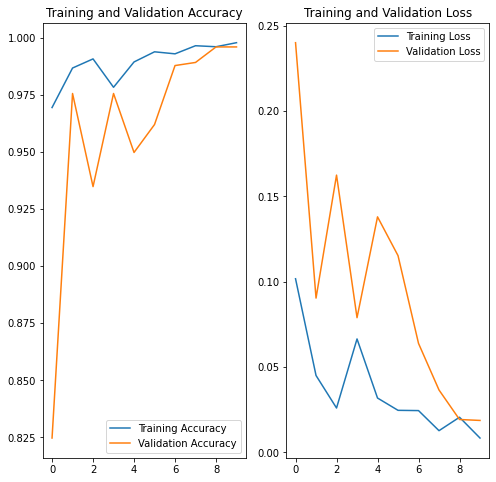

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [118]:
# os.mkdir('../data/weight')
model.save('../data/weight/resnet50.h5')


In [42]:
sample_pred_images, _ = next(predict_data_gen)

In [43]:
# この関数は、1行5列のグリッド形式で画像をプロットし、画像は各列に配置されます。
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

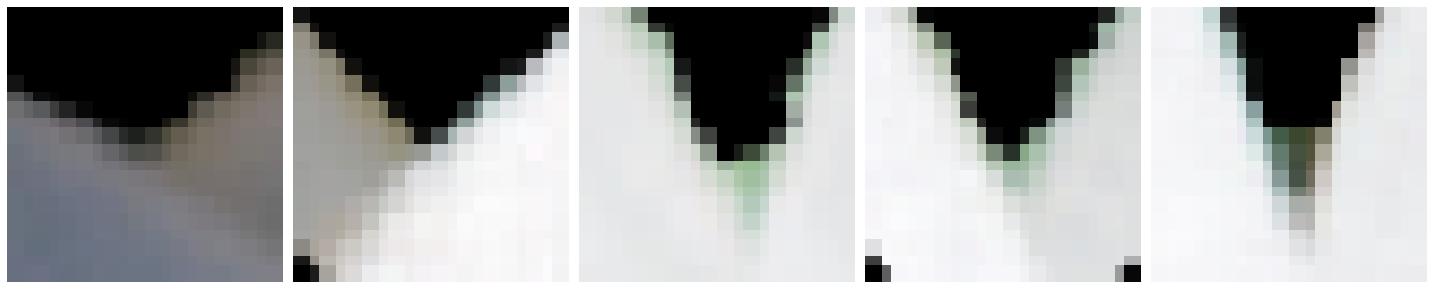

In [44]:
plotImages(sample_pred_images[5:10])

In [45]:
sample_pred_images.shape

(1636, 32, 32, 3)

In [23]:
list_ = sorted(os.listdir(path_data+'natural_img2/natural2'))[:]
len(list_)

1636

In [10]:
model = tf.keras.models.load_model('../data/weight/resnet50.h5')

In [46]:
pred = model.predict(sample_pred_images, batch_size=None, verbose=0, steps=None)

In [47]:
pred = np.hstack((list_, pred[:,0]))

In [48]:
pred.shape[0] -1636

1636

In [49]:
pred = pred.reshape(2,-1)
pred.shape

(2, 1636)

In [50]:
pd.DataFrame(pred).T.to_csv('../data/pred_resnet50_natural_prob.csv', header=False, index=False)

In [106]:
from PIL import Image
for i, bool_ in zip(np.arange(len(pred)), pred):
    img = np.array(sample_pred_images[i]*255, np.uint8)
    if bool_:
        Image.fromarray(img).save('../data/dataset/pred/right/'+str(i)+'.png')
    else:
        Image.fromarray(img).save('../data/dataset/pred/left/'+str(i)+'.png')

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [80]:
sample_train_images, _ = next(train_data_gen)

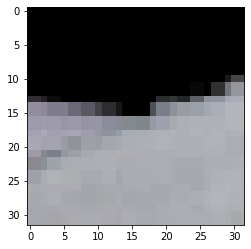

In [92]:
img = np.array(sample_train_images[1]*255, np.uint8)

plt.imshow(img)

In [85]:
pred = model.predict(sample_train_images, batch_size=None, verbose=0, steps=None) > 0.5

In [90]:
pred[:10]

array([[False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [ True]])